# AIID GraphQL API Examples / Tutorial

## Making requests


Let's start with a minimal request.
It queries the title of every incident in the database.

In [1]:
import requests
minimal_example_response = requests.post(
    'https://incidentdatabase.ai/api/graphql',
    data='{"query": "query { incidents { title } }"}',
    headers={"content-type": "application/json"}
)
minimal_example_response

<Response [200]>

In [2]:
minimal_example_response.json()['data']['incidents'][0:5]

[{'title': 'Las Vegas Self-Driving Bus Involved in Accident'},
 {'title': 'Uber AV Killed Pedestrian in Arizona'},
 {'title': 'Google’s YouTube Kids App Presents Inappropriate Content'},
 {'title': 'Gender Biases of Google Image Search'},
 {'title': 'Common Biases of Vector Embeddings'}]

We can put some of the scaffolding in a function.

In [3]:
import requests
import json

def post_query(query, variables={}):
    response = requests.post(
        'https://incidentdatabase.ai/api/graphql',
        data=json.dumps({ "query": query, "variables": variables }),
        headers={"content-type": "application/json"}
    )
    response_json = response.json()
    if response_json.get('errors'):
        raise Exception(response_json['errors'])
    return response_json['data']

In [4]:
post_query("query { incidents { title, incident_id } }")['incidents'][0:5]

[{'title': 'Las Vegas Self-Driving Bus Involved in Accident',
  'incident_id': 23},
 {'title': 'Uber AV Killed Pedestrian in Arizona', 'incident_id': 4},
 {'title': 'Google’s YouTube Kids App Presents Inappropriate Content',
  'incident_id': 1},
 {'title': 'Gender Biases of Google Image Search', 'incident_id': 18},
 {'title': 'Common Biases of Vector Embeddings', 'incident_id': 12}]

## Pagination and Using Variables

So far we've been requesting data for every incident in the database.
This will become infeasable as we request more data per field.
To handle this, we use pagination.

In [5]:
data = post_query("""
    query {
        incidents(pagination: {limit: 3}) {
            title
            date
            description
        }
    }
""")
print(json.dumps(data, indent=2))

{
  "incidents": [
    {
      "title": "Las Vegas Self-Driving Bus Involved in Accident",
      "date": "2017-11-08",
      "description": "A self-driving public shuttle by Keolis North America and Navya was involved in a collision with a human-driven delivery truck in Las Vegas, Nevada on its first day of service."
    },
    {
      "title": "Uber AV Killed Pedestrian in Arizona",
      "date": "2018-03-18",
      "description": "An Uber autonomous vehicle (AV) in autonomous mode struck and killed a pedestrian in Tempe, Arizona."
    },
    {
      "title": "Google\u2019s YouTube Kids App Presents Inappropriate Content",
      "date": "2015-05-19",
      "description": "YouTube\u2019s content filtering and recommendation algorithms exposed children to disturbing and inappropriate videos."
    }
  ]
}


In [6]:
page = -1

In [7]:
page += 1
data = post_query(
    """
    query ($pagination: PaginationType) {
        incidents(pagination: $pagination) {
            title
            date
            description
        }
    }
    """,
    variables={"pagination": { "limit": 3, "skip": 3 * page }}
)
print(json.dumps(data, indent=2))

{
  "incidents": [
    {
      "title": "Las Vegas Self-Driving Bus Involved in Accident",
      "date": "2017-11-08",
      "description": "A self-driving public shuttle by Keolis North America and Navya was involved in a collision with a human-driven delivery truck in Las Vegas, Nevada on its first day of service."
    },
    {
      "title": "Uber AV Killed Pedestrian in Arizona",
      "date": "2018-03-18",
      "description": "An Uber autonomous vehicle (AV) in autonomous mode struck and killed a pedestrian in Tempe, Arizona."
    },
    {
      "title": "Google\u2019s YouTube Kids App Presents Inappropriate Content",
      "date": "2015-05-19",
      "description": "YouTube\u2019s content filtering and recommendation algorithms exposed children to disturbing and inappropriate videos."
    }
  ]
}


Every time you run the above cell, it will produce the next "page" of 3 incidents.

## Incidents and Reports

Incidents in the AI Incident Database have one or more associated reports documenting them.
These can be queried within an incident query.

In [8]:
data = post_query(
    """
    query {
        incidents(pagination: { limit: 1 }) {
            title
            date
            description
            reports {
                title
                url
            }
        }
    }
    """
)
reports = data['incidents'][0]['reports'][0:3]
print(json.dumps(reports, indent=2))

[
  {
    "title": "Self-driving shuttle bus in crash on first day",
    "url": "https://www.bbc.com/news/technology-41923814"
  },
  {
    "title": "The real lesson of that self-driving shuttle\u2019s first-day accident",
    "url": "https://arstechnica.com/cars/2017/11/the-real-lesson-of-that-self-driving-shuttles-first-day-accident/"
  },
  {
    "title": "U.S. safety board to probe self-driving shuttle crash in Las Vegas",
    "url": "https://www.reuters.com/article/us-autos-selfdriving/u-s-safety-board-to-probe-self-driving-shuttle-crash-in-las-vegas-idUSKBN1DA2K1"
  }
]


Reports are a top-level collection, so they can also be queried independent of incidents, with pagination.

In [9]:
data = post_query(
    """
    query {
        reports(pagination: { limit: 3 }) {
            title
            url
        }
    }
    """
)
print(json.dumps(data, indent=2))

{
  "reports": [
    {
      "title": "Google\u2019s YouTube Kids App Criticized for \u2018Inappropriate Content\u2019",
      "url": "https://blogs.wsj.com/digits/2015/05/19/googles-youtube-kids-app-criticized-for-inappropriate-content/"
    },
    {
      "title": "YouTube Kids, Criticized for Content, Introduces New Parental Controls",
      "url": "https://www.nytimes.com/2018/04/25/business/media/youtube-kids-parental-controls.html"
    },
    {
      "title": "Children's YouTube is still churning out blood, suicide and cannibalism",
      "url": "https://www.wired.co.uk/article/youtube-for-kids-videos-problems-algorithm-recommend"
    }
  ]
}


## Filters

In [10]:
data = post_query(
    """
    query {
        reports(
            pagination: { limit: 3 }, 
            filter: { date_published: { GTE: "2024-01-01T00:00:00+00:00" }}
        ) {
            title
            url
            date_published
        }
    }
    """
)
print(json.dumps(data, indent=2))

{
  "reports": [
    {
      "title": "Dealership AI Chatbot Sells Car for $1",
      "url": "https://www.colombiaone.com/2024/01/08/gm-dealership-chatbot-ai/",
      "date_published": "2024-01-08T00:00:00.000Z"
    },
    {
      "title": "Lazy use of AI leads to Amazon products called \u201cI cannot fulfill that request\u201d",
      "url": "https://arstechnica.com/ai/2024/01/lazy-use-of-ai-leads-to-amazon-products-called-i-cannot-fulfill-that-request/",
      "date_published": "2024-01-12T00:00:00.000Z"
    },
    {
      "title": "FTC Announces Groundbreaking Action Against Rite Aid for Unfair Use of AI",
      "url": "https://www.wilmerhale.com/en/insights/blogs/wilmerhale-privacy-and-cybersecurity-law/20240111-ftc-announces-groundbreaking-action-against-rite-aid-for-unfair-use-of-ai",
      "date_published": "2024-01-11T00:00:00.000Z"
    }
  ]
}


In [11]:
data = post_query(
    """
    query {
        reports(
            pagination: { limit: 3 }, 
            filter: { 
                date_published: {
                    GTE: "2022-01-01T00:00:00+00:00",
                    LTE: "2023-01-01T00:00:00+00:00"
                },
                title: { REGEX: "ChatGPT" }
            }
        ) {
            title
            url
            date_published
        }
    }
    """
)
print(json.dumps(data, indent=2))

{
  "reports": [
    {
      "title": "Temporary policy: ChatGPT is banned",
      "url": "https://meta.stackoverflow.com/questions/421831/temporary-policy-chatgpt-is-banned",
      "date_published": "2022-12-05T00:00:00.000Z"
    },
    {
      "title": "ChatGPT proves that AI still has a racism problem",
      "url": "https://www.newstatesman.com/quickfire/2022/12/chatgpt-shows-ai-racism-problem",
      "date_published": "2022-12-10T00:00:00.000Z"
    },
    {
      "title": "ChatGPT bot tricked into giving bomb-making instructions, say developers",
      "url": "https://www.thetimes.co.uk/article/chatgpt-bot-tricked-into-giving-bomb-making-instructions-say-developers-rvktrxqb5",
      "date_published": "2022-12-17T00:00:00.000Z"
    }
  ]
}


## Comparing count of articles with given keywords over time

In [12]:
keyword_in_date_range_query = """
query ($keyword: String, $published_gte: DateTime, $published_lt: DateTime) {
  reports(
    filter: {
      plain_text: { REGEX: $keyword },
      date_published: {
        GTE: $published_gte,
        LT: $published_lt
      }
    }
  ) {
    title
  }
}
"""

We surround our keyword with `\W`s, which means "word boundary". This prevents matches on words containing "ai", like "rain." we also add `(?i)` to make the search case-insensitive.

In [13]:
ai_2020_2024 = post_query(
    keyword_in_date_range_query, 
    variables={
        'keyword': "\\W(?i)ai\\W",
        'published_gte': "2020-01-01T00:00:00+00:00",
        'published_lt': "2024-01-01T00:00:00+00:00",
    }
)
print(len(ai_2020_2024['reports']))

1126


By repeating the request, we can compare different keywords over time.

In [14]:
for year in range(2012, 2024, 4):
    lower = str(year)
    upper = str(year + 4)
    print(lower + "-" + upper)
    for keyword in "artificial intelligence", "machine learning":
        data = post_query(
            keyword_in_date_range_query, 
            variables={
                'keyword': "\\W(?i)" + keyword +"\\W",
                'published_gte': lower + "-01-01T00:00:00+00:00",
                'published_lt': upper + "-01-01T00:00:00+00:00",
            }
        )
        print('  ', keyword, len(data['reports']))
    print() 

2012-2016
   artificial intelligence 15
   machine learning 11

2016-2020
   artificial intelligence 226
   machine learning 150

2020-2024
   artificial intelligence 701
   machine learning 167



It turns out that usage of the term "artificial intelligence" has increased much more than "machine learning." This probably corresponds to machine learning systems becoming more widely known among the general public.

Let's factor this into a function 

In [15]:
def get_keyword_usage_over_time(keywords, binsize=4):
    result = {}
    for keyword in keywords:
        result[keyword] = {}
        for year in range(2012, 2024, binsize):
            lower = str(year)
            upper = str(year + binsize)
            range_string = lower + "-" + upper if binsize > 1 else lower
        
            data = post_query(
                keyword_in_date_range_query, 
                variables={
                    'keyword': "\\W(?i)" + keyword +"\\W",
                    'published_gte': lower + "-01-01T00:00:00+00:00",
                    'published_lt': upper + "-01-01T00:00:00+00:00",
                }
            )
            result[keyword][range_string] = len(data['reports'])
    return result

keyword_usage = get_keyword_usage_over_time(
    ("Facebook", "Google", "Microsoft", "OpenAI"),
    binsize=3
)
print(json.dumps(keyword_usage, indent=2))

{
  "Facebook": {
    "2012-2015": 6,
    "2015-2018": 125,
    "2018-2021": 124,
    "2021-2024": 243
  },
  "Google": {
    "2012-2015": 43,
    "2015-2018": 217,
    "2018-2021": 143,
    "2021-2024": 295
  },
  "Microsoft": {
    "2012-2015": 0,
    "2015-2018": 82,
    "2018-2021": 65,
    "2021-2024": 197
  },
  "OpenAI": {
    "2012-2015": 0,
    "2015-2018": 1,
    "2018-2021": 11,
    "2021-2024": 302
  }
}


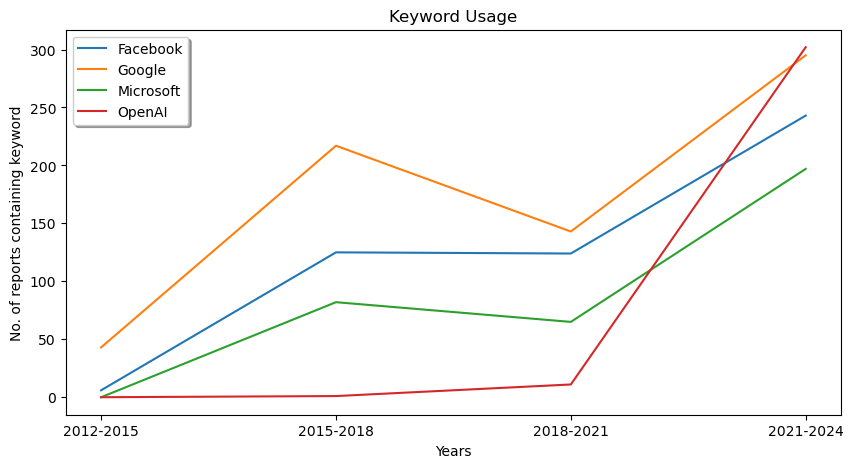

In [16]:
import matplotlib.pyplot as plt 

def make_graph(keyword_usage):
    fig = plt.figure(figsize = (10, 5))
    for keyword in keyword_usage.keys():
        plt.plot( keyword_usage[keyword].keys(), keyword_usage[keyword].values() )

    plt.legend(keyword_usage.keys(), shadow=True)
    plt.xlabel("Years")
    plt.ylabel("No. of reports containing keyword")
    plt.title("Keyword Usage")
    plt.show()

make_graph(keyword_usage)

Making repeating requests is slow, however, so we can speed it up by constructing a query combining many filters.

query {
                  keyword020122013:
                  reports(
                    filter: {
                      plain_text: { REGEX: "\\W(?i)Facebook\\W"},
                      date_published: {
                        GTE: "2012-01-01T00:00:00+00:00",
                        LT: "2013-01-01T00:00:00+00:00"
                      }
                    }
                  ) {
                    report_number
                  }
                
                  keyword020132014:
                  reports(
                    filter: {
                      plain_text: { REGEX: "\\W(?i)Facebook\\W"},
                      date_published: {
                        GTE: "2013-01-01T00:00:00+00:00",
                        LT: "2014-01-01T00:00:00+00:00"
                      }
                    }
                  ) {
                    report_number
                  }
                
                  keyword020142015:
                  reports(
                    filte

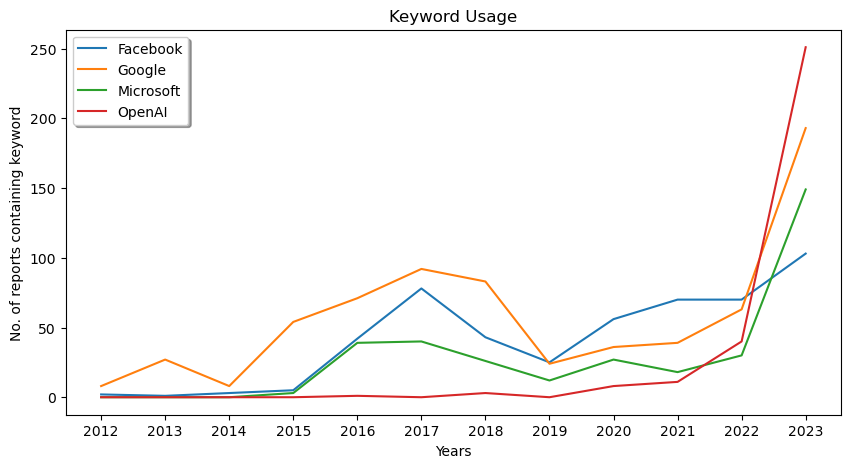

In [20]:
def get_keyword_usage_over_time_batched(keywords, start_year=2012, end_year=2024, binsize=4):
    result = {}
    query = "query {"
    
    for i, keyword in enumerate(keywords):
        for year in range(start_year, end_year, binsize):
            lower = str(year)
            upper = str(year + binsize)
        
            query += (
                """
                  __KEY__:
                  reports(
                    filter: {
                      plain_text: { REGEX: "__KEYWORD__"},
                      date_published: {
                        GTE: "__PUBLISHED_GTE__",
                        LT: "__PUBLISHED_LT__"
                      }
                    }
                  ) {
                    report_number
                  }
                """
                .replace("__KEYWORD__", "\\\\W(?i)" + keyword +"\\\\W")
                .replace("__PUBLISHED_GTE__", lower + "-01-01T00:00:00+00:00")
                .replace("__PUBLISHED_LT__", upper + "-01-01T00:00:00+00:00")
                .replace("__KEY__", "keyword" + str(i) + lower + upper)
            )
    query += "\n}"
    print(query)
    data = post_query(query)
    result = {}
    for i, keyword in enumerate(keywords):
        result[keyword] = {}
        for year in range(start_year, end_year, binsize):
            lower = str(year)
            upper = str(year + binsize)
            range_string = lower + "-" + upper if binsize > 1 else lower

            result[keyword][range_string] = len(data["keyword" + str(i) + lower + upper])
    return result

make_graph(get_keyword_usage_over_time_batched(
    (
        "Facebook",
        "Google",
        "Microsoft",
        "OpenAI",
    ),
    binsize=1
))

With this, [we can make all sorts of graphs](./word-usage-graphs.ipynb).